# Ensemble phase picking
- Yiyu Ni (niyiyu@uw.edu)
- Last updated: April 20, 2023

### import packages

In [1]:
import obspy
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ELEP/src/")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from ensemble_coherence import ensemble_semblance
from ensemble_statistics import ensemble_statistics
from trigger_func import picks_summary_simple
import seisbench.models as sbm
from tqdm import tqdm
from obspy.core.utcdatetime import UTCDateTime

### Load data
We read mSEED from [PB.B204](https://ds.iris.edu/gmap/#network=PB&station=B204&planet=earth) station, Jan 6, 2023. The stream contains 10-hour 3-component waveform from EH channel (short period high-gain).

We read the number of data points in each trace, delta (reciprocal of sampling rate), and start time of the trace.

In [2]:
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

client = Client("IRIS")

3 Trace(s) in Stream:
PB.B204..EH1 | 2023-01-06T14:00:00.008400Z - 2023-01-06T23:59:59.998400Z | 100.0 Hz, 3600000 samples
PB.B204..EH2 | 2023-01-06T14:00:00.008400Z - 2023-01-06T23:59:59.998400Z | 100.0 Hz, 3600000 samples
PB.B204..EHZ | 2023-01-06T14:00:00.008400Z - 2023-01-06T23:59:59.998400Z | 100.0 Hz, 3600000 samples


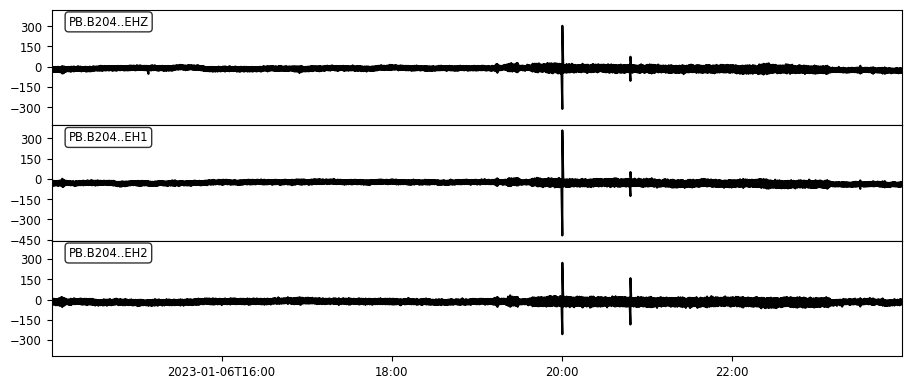

In [3]:
s = client.get_waveforms("PB", "B204", location = "*", channel = "EH?", 
                         starttime = UTCDateTime("2023-01-06T14:00:00.000000"), 
                         endtime   = UTCDateTime("2023-01-06T23:59:59.999000"))
print(s)
npts = s[0].stats.npts
delta = s[0].stats.delta
starttime = s[0].stats.starttime

fig =plt.figure(figsize = (10, 4))
s.plot(fig = fig);

### Baseline using original pretrianed model

In [4]:
# cut continuous data into one-minute time window (6000 sample for EqTransformer)
# 3000 (50%, 30 seconds) sample overlap 
# mute 500 samples of prediction on both end of time window

twin = 6000
step = 3000
l_blnd, r_blnd = 500, 500
nseg = int(np.ceil((npts - twin) / step)) + 1

In [5]:
eqt = sbm.EQTransformer.from_pretrained('original')
eqt.to(torch.device("cuda"));
eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples (only for window prediction models)',
 step)
eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on each side of each window prediction',
 (l_blnd, r_blnd))
eqt.eval();
[print(i) for i in eqt.classify(s)[0]];

PB.B204.	2023-01-06T20:00:18.178400Z	P
PB.B204.	2023-01-06T20:00:19.298400Z	S
PB.B204.	2023-01-06T20:48:19.888400Z	P
PB.B204.	2023-01-06T20:48:20.998400Z	S


## cut and predict on time windows
We cut the continuous data into small time windows with overlap. Then, we pre-process the stream and the windowed waveform: switch channel order, demean, normalization, and taper.

Note that `original` pretrain model use std normalization, while others use maximum normalization. Thus, we create two different windowed data: `windows_std` and `windows_max`.

In [6]:
s2 = eqt.annotate_stream_pre(s.copy(), argdict=eqt._annotate_args)
sdata = np.array(s2)[[2,0,1], :] #12Z

windows_std = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_max = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
_windows = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
windows_idx = np.zeros(nseg, dtype=np.int32)
tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))

for iseg in range(nseg):
    idx = iseg * step
    _windows[iseg, :] = sdata[:, idx:idx + twin]
    _windows[iseg, :] -= np.mean(_windows[iseg, :], axis=-1, keepdims=True)
    # original use std norm
    windows_std[iseg, :] = _windows[iseg, :] / np.std(_windows[iseg, :]) + 1e-10
    # others use max norm
    windows_max[iseg, :] = _windows[iseg, :] / np.max(np.abs(_windows[iseg, :]), axis=-1, keepdims=True) + 1e-10
    windows_idx[iseg] = idx

windows_std[:, :, :6] *= tap; windows_std[:, :, -6:] *= tap[::-1]; 
windows_max[:, :, :6] *= tap; windows_max[:, :, -6:] *= tap[::-1];
del _windows

Then we use EqTransformer model to perform prediction on each of the time window. We use six different pre-trained model, listed in `pretrain_list`. We loop over these pretrain weights, and save the results in `batch_pred` variable of shape [2, 6, 1199, 6000]. Understanding the shape of this varibale is important:
- 2: one for P-wave and another for S-wave. We don't save detection branch.
- 6: six pretrained weights
- 1199: the number of windows
- 6000: the length of each time window

In [7]:
pretrain_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'neic']

# dim 0: 0 = P, 1 = S
batch_pred = np.zeros([2, len(pretrain_list), nseg, twin], dtype = np.float32) 

for ipre, pretrain in enumerate(pretrain_list):
    print(pretrain)
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(torch.device("cuda"));
    eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples (only for window prediction models)',
     step)
    eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on each side of each window prediction',
     (l_blnd, r_blnd))
    eqt.eval();
    if pretrain == 'original':
        # batch prediction through torch model
        _torch_pred = eqt(torch.Tensor(windows_std).to(torch.device("cuda")))
    else:
        _torch_pred = eqt(torch.Tensor(windows_max).to(torch.device("cuda")))
    batch_pred[0, ipre, :] = _torch_pred[1].detach().cpu().numpy()
    batch_pred[1, ipre, :] = _torch_pred[2].detach().cpu().numpy()
del _torch_pred, windows_std, windows_max
print(batch_pred.shape)

original
ethz
instance
scedc
stead
neic
(2, 6, 1199, 6000)


## stacking
This section we merge all time windows into the continuous prediction. We use the `stacking` function: it takes matrix of shape [nseg, ntrace] and merge it into an 1D array.

In [8]:
def stacking(data, npts, l_blnd, r_blnd):
    _data = data.copy()
    stack = np.full(npts, np.nan, dtype = np.float32)
    _data[:, :l_blnd] = np.nan; _data[:, -r_blnd:] = np.nan
    stack[:twin] = _data[0, :]
    for iseg in range(nseg-1):
        idx = step*(iseg+1)
        stack[idx:idx + twin] = \
                np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)
    return stack

We first merge results from each of the pretrained model, respectively.

In [9]:
pretrain_pred = np.zeros([2, len(pretrain_list), npts], dtype = np.float32)
for ipre, pretrain in enumerate(pretrain_list):
    pretrain_pred[0, ipre, :] = stacking(batch_pred[0, ipre, :], npts, l_blnd, r_blnd)
    pretrain_pred[1, ipre, :] = stacking(batch_pred[1, ipre, :], npts, l_blnd, r_blnd)

/tmp/ipykernel_2971312/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


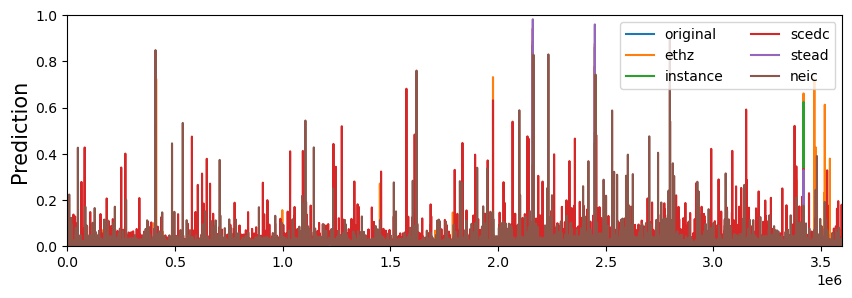

In [10]:
plt.figure(figsize = (10, 3))
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

## ensemble on time windows
We then apply the ensemble measurement on each of the time window, and then merge them.

In [11]:
paras_simple = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':False, 
                   'semblance_win':0.5, 'weight_flag':'max'}

max_pred = np.zeros([2, nseg, twin], dtype = np.float32)
smb_pred = np.zeros([2, nseg, twin], dtype = np.float32)

In [12]:
for iseg in range(nseg):
    max_pred[0, iseg, :] = ensemble_statistics(batch_pred[0, :, iseg, :], paras_simple)
    smb_pred[0, iseg, :] = ensemble_semblance(batch_pred[0, :, iseg, :], paras_semblance)
    
    max_pred[1, iseg, :] = ensemble_statistics(batch_pred[1, :, iseg, :], paras_simple)
    smb_pred[1, iseg, :] = ensemble_semblance(batch_pred[1, :, iseg, :], paras_semblance)

In [13]:
max_p = stacking(max_pred[0, :], npts, l_blnd, r_blnd)
smb_p = stacking(smb_pred[0, :], npts, l_blnd, r_blnd)

max_s = stacking(max_pred[1, :], npts, l_blnd, r_blnd)
smb_s = stacking(smb_pred[1, :], npts, l_blnd, r_blnd)
del max_pred, smb_pred, batch_pred

/tmp/ipykernel_2971312/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


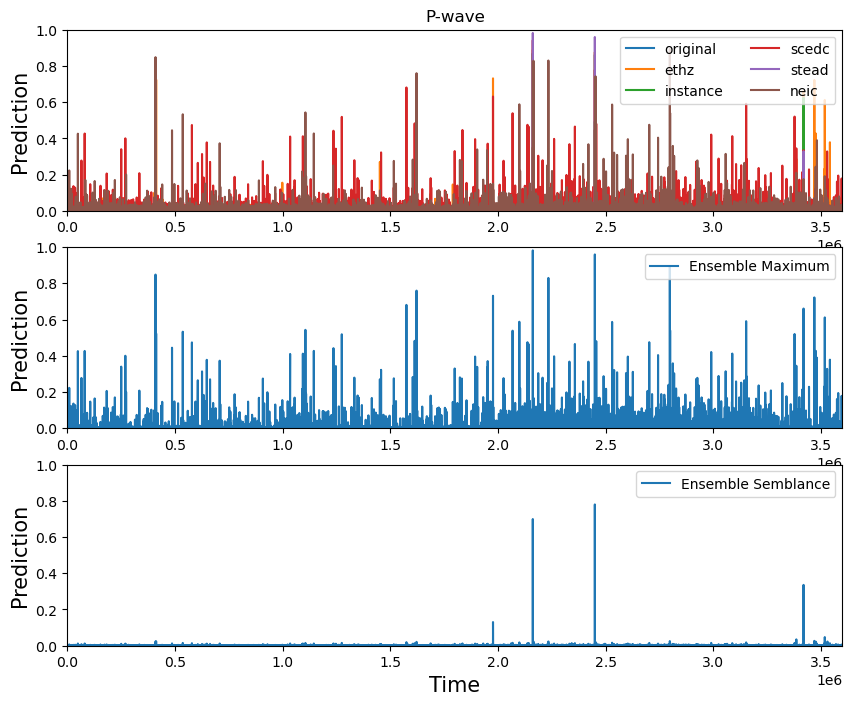

In [14]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("P-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_p, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_p, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

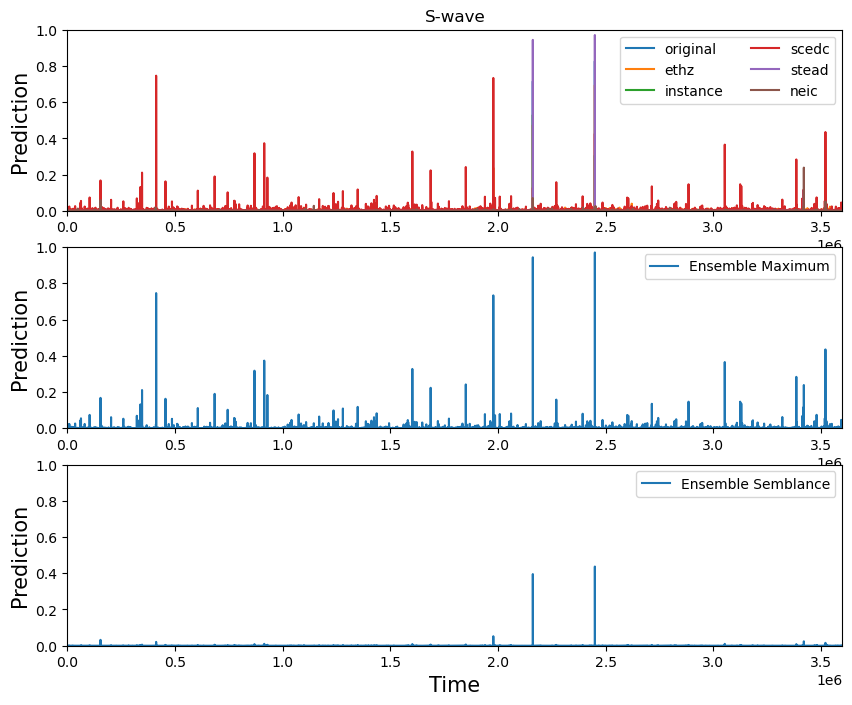

In [15]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("S-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[1, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_s, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_s, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

# EOF